# modelling agential learning in the two-agent agency task using active inference

non-exhaustive list of variables you can play around with on this script:
* expcondition: this manipulates the experimental condition. You may specify it to be a certain condition from the following list: ['Positive Control', 'Negative Control', 'Zero Control']. You may also set it to None and let the script randomly select an experimental condition from the list.

* p_outcome_env: this manipulates how volatile the environment (generative process) is. 1.0 is a fully deterministic environment - i.e., in the experimental condition of positive agency, every time the agent presses the button, the light turns on 100% of the time. If set to 0.8, then the environment is probabilistic or volatile - i.e., every time the agent presses the button, the light turn on 80% of the time.

* p_outcome: this manipulates how volatile the agent believes the environment is, and it is reflected in its generative model's A tensor. The agent may then learn how volatile the environment actually is by updating its A tensor at every timestep.
* outcomepref: this sets the preference for the outcome. Set it as high or low as you wish.

* actionpref: this sets the preference for producing an action (i.e., pressing the button).

* noactionpref: this sets the preference for not producing an action (i.e., not pressing the button), and can be interpreted as having a cost towards producing an action.

* lr_pA: this is the learning rate parameter for learning/updating of the A tensor. 



#### prerequisites (loading packages)

In [22]:
# !pip install inferactively-pymdp # the sparse-likelilihoods_111 branch was used here
import os
import sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import pymdp
from pymdp import utils 
from pymdp import maths
from pymdp.agent import Agent

### THE GENERATIVE MODEL

#### specifying the states and observations

In [23]:
""" Defining state factors """
self_agency_names = ['Positive Control', 'Negative Control', 'Zero Control']
self_action_names = ['Button Pressed', 'Button Not Pressed']

""" Defining number of state factors and states """
num_states = [len(self_agency_names), len(self_action_names)]
num_factors = len(num_states)

""" Defining control state factors """
choice_self_agency_names = ['no_changes']
choice_self_action_names = ['pressbutton', 'notpressbutton']

""" Defining number of control states """
num_controls = [len(choice_self_agency_names), len(choice_self_action_names)]

""" Defining observational modalities """
obs_outcome_names = ['Outcome Present', 'Outcome Absent']
obs_choice_self_names = ['Button Pressed', 'Button Not Pressed']

""" Defining number of observational modalities and observations """
num_obs = [len(obs_outcome_names), len(obs_choice_self_names)]
num_modalities = len(num_obs)

#### likelihood (A) tensors

In [24]:
def create_A(p_outcome):
    
    A_gp = utils.obj_array(num_modalities)
    
    ''' A matrix for outcome '''
    
    A_outcome = np.zeros( (len(obs_outcome_names), len(self_agency_names), len(self_action_names)) )
    
    # SELF_POS
    
    # p(outcome | self_pos, self_press)
    #                    present       absent
    A_outcome[:,0,0] = [p_outcome, 1.0-p_outcome]
    
    # p(outcome | self_pos, self_notpress)
    #                    present       absent
    A_outcome[:,0,1] = [1.0-p_outcome, p_outcome]
    
    
    # SELF_NEG
    
    # p(outcome | self_neg, self_press)
    #                    present       absent
    A_outcome[:,1,0] = [1.0-p_outcome, p_outcome]
    
    # p(outcome | self_neg, self_notpress)
    #                    present       absent
    A_outcome[:,1,1] = [p_outcome, 1.0-p_outcome]
    
    
    # SELF_ZERO
    
    # p(outcome | self_zero, self_press)
    #                   pre  abs
    A_outcome[:,2,0] = [0.5, 0.5]
    
    # p(outcome | self_zero, self_notpress)
    #                   pre  abs
    A_outcome[:,2,1] = [0.5, 0.5]

    ''' A matrix for proprioception '''
    A_choice_self = np.zeros((len(obs_choice_self_names), len(self_action_names)))
    
    A_choice_self = np.eye(len(self_action_names))
    
    
    ''' stacking up the A matrices '''
    A_gp[0], A_gp[1] = A_outcome, A_choice_self
    A_factor_list = [[0,1], [1]]
    
    A_gp = utils.norm_dist_obj_arr(A_gp)
    
    pA = utils.dirichlet_like(A_gp, scale = 1.0)

    pA[0] = pA[0] / np.sum(pA[0])

    A = utils.norm_dist_obj_arr(pA) 
    
    return A, A_factor_list, pA

controllable_indices = [1]
learnable_modalities = [0]

#### state transition (B) tensors

In [25]:
def create_B():
    
    B = utils.initialize_empty_B(num_states, num_states)
    
    ''' B matrix for context regarding the self '''
    B_self_context = np.zeros( (len(self_agency_names), len(self_agency_names), len(choice_self_agency_names)) )
    B_self_context[:,:,0] = np.eye(len(self_agency_names))
    
    # B_self_context = pymdp.maths.softmax_obj_arr(B_self_context)
    # B_self_context = maths.softmax(B_self_context)

    ''' B matrix for actions the self can make '''
    B_self_choice = np.zeros( (len(self_action_names), len(self_action_names), len(choice_self_action_names)) )
    
    for choice_id in range(len(self_action_names)):
        B_self_choice[choice_id, :, choice_id] = 1.0
    
    ''' stacking up the B matrices '''
    B[0], B[1] = B_self_context, B_self_choice
    
    B = utils.norm_dist_obj_arr(B)
    
    return B

#### preferences (C) vectors

In [26]:
def create_C(outcomepref, actionpref, noactionpref):
        
    C = utils.obj_array_zeros(num_obs)
    C[0] = np.array([outcomepref, 0.0])
    C[1] = np.array([actionpref, noactionpref])
    
    return C

#### priors (D) vectors

In [27]:
def create_D():
    
    D = utils.obj_array(num_factors)
    
    D_self_context = np.ones(num_states[0])/float(num_states[0])
    
    D_self_choice = np.zeros(len(self_action_names)) 
    D_self_choice = np.ones(num_states[1])/float(num_states[1])

    D[0], D[1] = D_self_context, D_self_choice
    
    return D

### THE GENERATIVE PROCESS
i.e., the true (experimenter's) environment

In [28]:
class AgencyTask(object):
    
    def __init__(self, expcondition = None, p_outcome_env = 1.0):
        
        # defining the experimental conditions for the generative process
#         self.expcondition_names = ['s_pos_o_zer', 's_neg_o_zer',
#                                    's_zer_o_pos', 's_zer_o_neg', 
#                                    's_zer_o_zer']
        
        self.expcondition_names = ['Positive Control', 'Negative Control', 'Zero Control']
        
        self.num_expcondition = len(self.expcondition_names)
        
        if expcondition == None:
            self.expcondition = self.expcondition_names[utils.sample(np.ones(self.num_expcondition)/self.num_expcondition)] # randomly sample which context is selected
        else:
            self.expcondition = expcondition
            
        self.p_outcome = p_outcome_env
        
        self.obs_outcome_names = ['Outcome Present', 'Outcome Absent']
                
    def step(self, action):

        # defining what happens in the generative process: what observations are presented to the agent given certain states (actions and context)
        if action == "pressbutton":
            observed_choice_self = "Button Pressed"
            
            if self.expcondition == 'Positive Control':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 'Negative Control':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 'Zero Control':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.5, 0.5]))]
            
        elif action == "notpressbutton":
            observed_choice_self = "Button Not Pressed"
            
            if self.expcondition == 'Positive Control':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([1.0-self.p_outcome, self.p_outcome]))]
            elif self.expcondition == 'Negative Control':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([self.p_outcome, 1.0-self.p_outcome]))]
            elif self.expcondition == 'Zero Control':
                observed_outcome = self.obs_outcome_names[utils.sample(np.array([0.5, 0.5]))]
            
        obs = [observed_outcome, observed_choice_self]

        return obs

### RUNNING ACTIVE INFERENCE 

In [29]:
def run_active_inference_loop(my_agent, my_env, T, verbose):

    choice_self_hist = np.zeros((num_controls[1],T))
    
    belief_self_context_hist = np.zeros((num_states[0], T))
    belief_self_action_hist = np.zeros((num_states[1], T))
    
    expcondition_hist = np.zeros(T)
    outcome_hist = np.zeros((num_obs[0],T))
    
    pA_hist = []
    
    for t in range(T):
        
        q_pi, efe = my_agent.infer_policies_factorized()
        
        chosen_action_id = my_agent.sample_action()
        action_id = int(chosen_action_id[1])
        choice_self_hist[action_id,t]= 1.0
        choice_action = choice_self_action_names[action_id]
        
        obs_label = my_env.step(choice_action)
        obs = [obs_outcome_names.index(obs_label[0]), obs_choice_self_names.index(obs_label[1])]
        
        expcondition_hist[t] = env.expcondition_names.index(env.expcondition)
        
        qs = my_agent.infer_states(obs)
        belief_self_context_hist[:,t] = qs[0]
        belief_self_action_hist[:,t] = qs[1]
        
        outcome_hist[obs[0],t] = 1.0
        
        pA_t = my_agent.update_A(obs)
        pA_hist.append(pA_t)
        
#         print(t)
#         print(efe)
#         print(q_pi)
        # print(t)
        # print()
        # print(obs)
        # print(my_agent.A[0][:,:,0])
        # print(my_agent.A[0][:,:,1])
            
    return choice_self_hist, belief_self_context_hist, expcondition_hist, outcome_hist, pA_hist

In [30]:
# FOR DETERMINISTIC VERSION OF THE TASK
p_outcome_env = 1.0

env = AgencyTask(p_outcome_env = p_outcome_env)

T = 25

A,A_factor_list,pA = create_A(p_outcome = 1.0)
B = create_B()

C = create_C(outcomepref = 5.0, actionpref = 0.0, noactionpref = 0.0)
D = create_D()
my_agent = Agent(A=A, B=B, C=C, D=D, A_factor_list=A_factor_list,
                 pA=pA, control_fac_idx=controllable_indices,
                 modalities_to_learn=learnable_modalities,
                 lr_pA=0.05, use_param_info_gain=True)


choice_self_hist, belief_self_context_hist, expcondition_hist, outcome_hist, pA_hist = run_active_inference_loop(my_agent, env, T = T, verbose = False)

### PLOTTING 

In [31]:
def plot_all_choices_beliefs(choice_self_hist, belief_self_context_hist, expcondition_hist, outcome_hist, pad_val=1.0):
    
    print(f'Experimental Condition: {env.expcondition}')
    
    T = choice_self_hist.shape[1]
    fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (15,7))
    
    axes[0].imshow(belief_self_context_hist, cmap = 'gray', vmin=0, vmax=1)
    # axes[0].imshow(belief_self_context_hist, cmap = 'gray')
    axes[0].set_xlabel('Timesteps')
    axes[0].set_yticks(ticks = range(num_states[0]))
    axes[0].set_yticklabels(labels = self_agency_names)
    axes[0].set_title('Beliefs about control the self has over time')

    axes[1].imshow(choice_self_hist[:,:-1], cmap = 'gray', vmin=0, vmax=1) 
    # axes[1].imshow(choice_self_hist[:,:-1], cmap = 'gray') 
    axes[1].set_xlabel('Timesteps')
    axes[1].set_yticks(ticks = range(num_states[1]))
    axes[1].set_yticklabels(labels = self_action_names)
    axes[1].set_title('Actions produced by the agent over time')

    axes[2].imshow(outcome_hist[:,:-1], cmap = 'gray', vmin=0, vmax=1) 
    # axes[2].imshow(outcome_hist[:,:-1], cmap = 'gray') 
    axes[2].set_xlabel('Timesteps')
    axes[2].set_yticks(ticks = range(num_obs[0]))
    axes[2].set_yticklabels(labels = obs_outcome_names)
    axes[2].set_title('Outcomes observed over time')

    fig.tight_layout(pad=pad_val)
    plt.show()

Experimental Condition: Zero Control


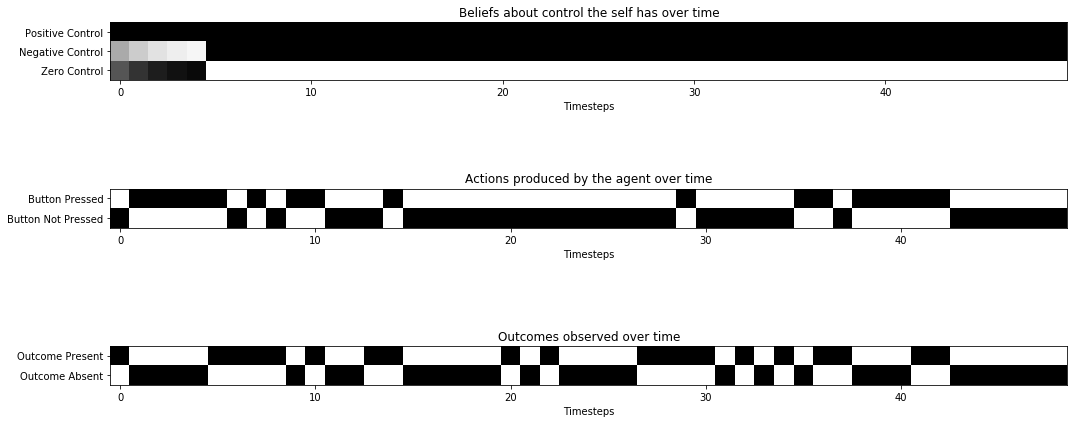

In [32]:
plot_all_choices_beliefs(choice_self_hist, belief_self_context_hist, expcondition_hist, outcome_hist)